<a href="https://colab.research.google.com/github/KonstantinElfimow/milk-yield-prediction/blob/main/milk_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://drive.google.com/file/d/1lmAZVHQcD04cLp6ftzlTDc-1_59SYdES/view?usp=drive_link

In [ ]:
! gdown --id 1lmAZVHQcD04cLp6ftzlTDc-1_59SYdES

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lmAZVHQcD04cLp6ftzlTDc-1_59SYdES
To: /content/milk_yield.csv
100% 6.83k/6.83k [00:00<00:00, 21.5MB/s]


ТЗ: Фермерское хозяйство планирует купить дополнительных коров к себе на ферму.
Руководитель активно использует аналитические технологии для принятия решений.
И для покупки коров он тоже хочет подойти по-современному.
А именно - найти зависимость между факторами кормления, самого молока и типа коровы с уровнем удоя.
Т.е построить прогнозную модель для удоя молока, исходя из разных факторов.
И использовать эту модель для покупки новых коров - покупать только тех, кто будет производить наибольшее количество молока.

# 1. Подготовка данных

## 1.1 Проведение обзора данных

### 1.1.1 Загрузка данных

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [104]:
# Дано:

# id - номер коровы в базе
# удой - годичный удой молока у коровы в кг
# протеин - показывает средний уровень протеина в корме.
# спо - сахаро-протеиновое отношение. Число, показывает качество кормления
# эке - энергетическая кормовая единица. Число, показывает качество кормления
# порода - порода коровы. В базе две породы коров: Вис Бик Айдиал, РефлешнСоверинг

In [105]:
df = pd.read_csv('/content/milk_yield.csv',
                 encoding='cp1251',
                 sep=';',
                 decimal=',',
                 skipinitialspace=True)
df.columns = df.columns.str.lower().str.replace(' ', '')

### 1.1.2 Получение общей информации о таблицах

In [106]:
# напишем функцию первичяной проверки данных
def check_data(data_df):
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object']).T)

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object']).T)

  print('\033[1m' + '\nВывод уникальных значений'\
  ' по каждому признаку:' + '\033[0m')

  for i in data_df.columns:
    print('\033[1m' + str(i) + '\033[0m')
    display(data_df[i].value_counts())

In [107]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          152 non-null    int64  
 1   удой        152 non-null    int64  
 2   эке         152 non-null    float64
 3   протеин     150 non-null    float64
 4   спо         152 non-null    float64
 5   порода      152 non-null    object 
 6   жирность,%  152 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 8.4+ KB
None

Проверка пропусков
Количество пропусков:
2
Доля пропусков:
id            0.000000
удой          0.000000
эке           0.000000
протеин       0.013158
спо           0.000000
порода        0.000000
жирность,%    0.000000
dtype: float64

Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


,id,удой,эке,протеин,спо,порода,"жирность,%"
0,1,5863,14.2,1743.0,0.89,Вис Бик Айдиал,3.58
1,2,5529,12.8,2138.0,0.94,Вис Бик Айдиал,3.54
2,3,5810,14.0,1854.0,0.93,РефлешнСоверинг,103.59
3,4,5895,12.4,2012.0,0.89,РефлешнСоверинг,3.40
4,5,5302,12.8,NaN,0.93,Вис Бик Айдиал,3.73
5,6,5254,12.7,1806.0,0.89,РефлешнСоверинг,3.13
6,7,5910,12.2,NaN,0.93,Вис Бик Айдиал,3.48
7,8,6179,14.7,1806.0,0.93,Вис Бик Айдиал,3.55
8,9,6783,14.2,1918.0,0.94,РефлешнСоверинг,3.71
9,10,5339,13.4,1791.0,0.89,Вис Бик Айдиал,3.13



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
id,152.0,76.500000,44.022721,1.00,38.75,76.500,114.25,152.00
удой,152.0,10085.914474,49237.632111,5039.00,5667.00,6131.000,6529.00,613100.00
эке,152.0,14.575000,1.325764,11.50,13.70,14.600,15.70,16.80
протеин,150.0,1936.840000,181.193733,1664.00,1791.00,1897.500,2096.50,2343.00
спо,152.0,0.921447,0.032641,0.84,0.93,0.940,0.94,0.95
"жирность,%",152.0,4.250263,8.112760,3.03,3.53,3.705,3.72,103.59



Описание категориальных данных:


,count,unique,top,freq
порода,152,3,Вис Бик Айдиал,108



Вывод уникальных значений по каждому признаку:
id


1      1
105    1
98     1
99     1
100    1
      ..
52     1
53     1
54     1
55     1
152    1
Name: id, Length: 152, dtype: int64

удой


5591    2
6267    2
5895    2
6572    2
6248    1
       ..
6353    1
5517    1
5378    1
5383    1
5894    1
Name: удой, Length: 148, dtype: int64

эке


15.7    8
14.7    8
14.6    7
14.2    6
15.2    6
14.1    5
13.9    5
16.3    5
15.5    5
16.4    5
13.4    5
15.9    4
14.9    4
14.4    4
16.5    4
12.8    4
15.8    4
16.1    3
11.8    3
14.8    3
14.0    3
13.7    3
14.3    3
12.7    3
15.6    3
16.2    3
12.9    3
12.5    2
13.8    2
12.1    2
15.1    2
16.6    2
13.5    2
12.3    2
16.7    2
12.4    2
13.3    2
14.5    2
12.2    2
13.2    2
13.6    1
16.8    1
11.5    1
16.0    1
15.3    1
13.1    1
15.4    1
Name: эке, dtype: int64

протеин


1703.0    3
1769.0    3
1873.0    2
2246.0    2
1797.0    2
         ..
1974.0    1
1932.0    1
2146.0    1
1830.0    1
2156.0    1
Name: протеин, Length: 129, dtype: int64

спо


0.94    71
0.93    30
0.95    14
0.89    10
0.85    10
0.88     9
0.84     7
0.92     1
Name: спо, dtype: int64

порода


Вис Бик Айдиал         108
РефлешнСоверинг         37
РефлешнСоверинггггг      7
Name: порода, dtype: int64

жирность,%


3.72      29
3.73      23
3.71      21
3.58      11
3.61       9
3.57       7
3.53       6
3.49       6
3.48       5
3.26       4
3.70       4
3.13       3
3.44       3
3.59       2
3.74       2
3.11       2
3.25       2
3.18       1
3.38       1
103.59     1
3.40       1
3.16       1
3.22       1
3.24       1
3.03       1
3.21       1
3.54       1
3.31       1
3.55       1
3.34       1
Name: жирность,%, dtype: int64

На этапе исследования данных выяснилось:
1. Есть пропуски в факторе "протеин".
2. Есть выброс в большую сторону у целевой "удой".
3. Есть выброс в большую сторону у фактора "жирность".
4. В названиях пород есть ошибки: вместо РефлешнСоверинг написано РефлешнСоверинггггг.
5. Совершенно ясно, что "жирность,%" это такая же целевая переменная, как и "удой" в данной задаче. Просто руководствуемся здравым смыслом.

**Вывод:**
1. Пропуски удалить.
2. Вместо обнаруженных выбросов подставить медиану значений фактора, исходя из породы коровы. Я буду использовать расчёта уровня выброса использовать метод тройного интерквартильного размаха.
3. Исправить ошибки в названии категории пород.

In [108]:
# Удаляем пропуски
df = df.dropna()
# Обрабатываем выбросы
for numeric_var in ('удой', 'жирность,%'):
    q1, q3 = df[numeric_var].quantile(0.25), df[numeric_var].quantile(0.75)
    H = q3 - q1
    replace = df[q3 + 3 * H < df[numeric_var]].index.to_list()
    df.loc[replace, numeric_var] = df.groupby('порода')[numeric_var].transform('median')
# Исправляем ошибки в названии пород
df['порода'] = df['порода'].apply(lambda x: 'РефлешнСоверинг'
                                  if x == 'РефлешнСоверинггггг'
                                  else x)

### 1.2.1 Графическое представление данных (корреляция между удоем и признаками по всей таблице)

In [109]:
df

,id,удой,эке,протеин,спо,порода,"жирность,%"
0,1,5863,14.2,1743.0,0.89,Вис Бик Айдиал,3.58
1,2,5529,12.8,2138.0,0.94,Вис Бик Айдиал,3.54
2,3,5810,14.0,1854.0,0.93,РефлешнСоверинг,3.71
3,4,5895,12.4,2012.0,0.89,РефлешнСоверинг,3.40
5,6,5254,12.7,1806.0,0.89,РефлешнСоверинг,3.13
...,...,...,...,...,...,...,...
147,148,5072,12.3,1815.0,0.84,Вис Бик Айдиал,3.18
148,149,6075,15.2,1864.0,0.94,Вис Бик Айдиал,3.71
149,150,5675,14.1,1814.0,0.94,Вис Бик Айдиал,3.59
150,151,6221,14.7,2156.0,0.93,Вис Бик Айдиал,3.72


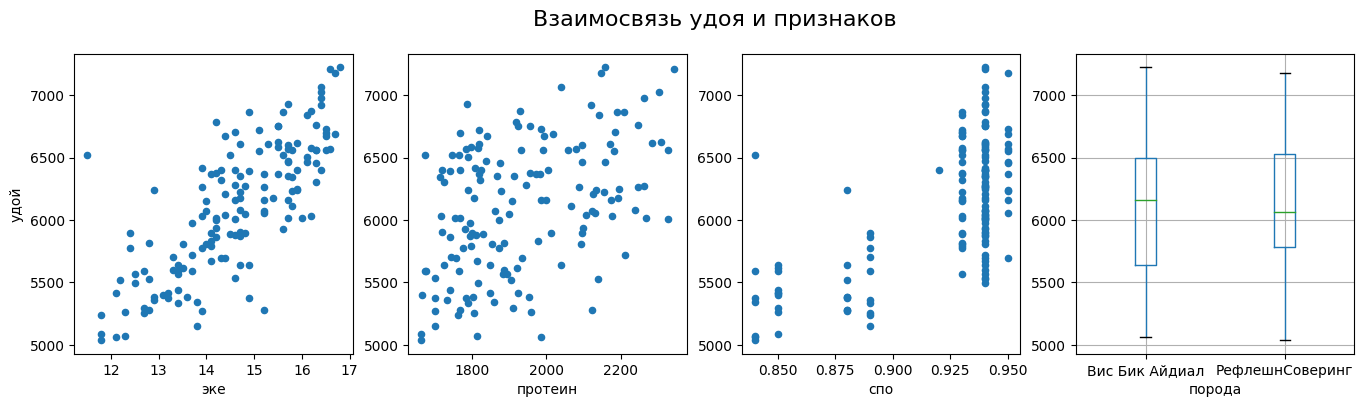

In [110]:
plt.rcParams.update(plt.rcParamsDefault)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

df.plot(kind='scatter', x='эке', y='удой', ax=axes[0])
axes[0].set_xlabel('эке')
axes[0].set_ylabel('удой')
axes[0].set_title('')

df.plot(kind='scatter', x='протеин', y='удой', ax=axes[1])
axes[1].set_xlabel('протеин')
axes[1].set_ylabel('')
axes[1].set_title('')

df.plot(kind='scatter', x='спо', y='удой', ax=axes[2])
axes[2].set_xlabel('спо')
axes[2].set_ylabel('')
axes[2].set_title('')

df.boxplot(by='порода', column='удой', ax=axes[3])
axes[3].set_xlabel('порода')
axes[3].set_ylabel('')
axes[3].set_title('')

plt.suptitle('Взаимосвязь удоя и признаков', fontsize=16, y=1.01)
plt.show()

Вывод: можно пронаблюдать нелинейную зависимость "спо" и "удоя" до и после 0.9. Поэтому приведу спо к категории

In [111]:
df['спо'] = df['спо'].apply(lambda x: 'менее_09'
                            if x <= 0.9
                            else 'более_09')

# 2. Моделирование

In [112]:
SIZE = 0.15
RANDOM_STATE = 42

categories = ['порода', 'спо']
numerics = ['эке', 'протеин']
target = ['удой']

In [113]:
features = df[categories + numerics]
targ = df[target]
x_train, x_test, y_train, y_test = train_test_split(features, targ,
                                                    test_size=SIZE,
                                                    random_state=RANDOM_STATE)

## 2.1 Приведение бинарных категорий к 0 и 1

In [114]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

def get_ohe(t, categ):
    temp = pd.DataFrame(data=ohe.transform(t[categ]), columns=ohe.get_feature_names_out())
    data = pd.concat([t.reset_index(drop=True), temp], axis=1)
    data = data.drop(columns=categ, axis=1)
    return data

ohe.fit(x_train[categories])
x_train = get_ohe(x_train, categories)
x_test = get_ohe(x_test, categories)

## 2.2 Масштабирование данных

In [115]:
scaler = StandardScaler()
scaler.fit(x_train[numerics])
x_train[numerics] = scaler.transform(x_train[numerics])
x_test[numerics] = scaler.transform(x_test[numerics])

## 2.3 Линейная регрессия

In [116]:
model = LinearRegression().fit(x_train, y_train)

In [117]:
prediction = model.predict(x_test)

In [118]:
# метрики, переведённые в проценты
r2 = round(r2_score(y_test, prediction.flatten()) * 100, 2)
mape = round(mean_absolute_percentage_error(y_test, prediction.flatten()) * 100, 2)

In [119]:
print('r2, %: ', r2)
print('mape, %: ', mape)

r2, %:  79.7
mape, %:  3.16


In [120]:
coeff_df = pd.DataFrame(model.coef_.flatten(), x_test.columns, columns=['коэффициенты_модели'])
coeff_df.sort_values(by='коэффициенты_модели', ascending=False)

,коэффициенты_модели
эке,283.793166
порода_РефлешнСоверинг,74.088691
протеин,60.417210
спо_менее_09,-332.492727


**Выводы:**
1. Можно заметить, что ЭКЕ оказывает наибольшее положительное влияние на удой.
2. Потом замечаем, что нужно ориентиноваться на породу Рефлешн Соверинг, так как она приносит больше удоя по сравнению с Вис Бик Айдиал.
3. То, сколько потребляет корова белка, тоже положительно влияет на удой.
4. СПО должно быть больше 0.9, так как категория спо_менее_09 в уменьшает количество удоя.

# 3. Проверка качества модели

In [121]:
def quality_model(fact, pred):
  '''
  Функция выводит:
  - R2 для регрессионных моделей
  - Графики остатков: гистограмма, скаттерплот "отстатки - предсказанные значения"
  '''
  params = {'axes.labelsize': 14, 'figure.titlesize': 18, 'xtick.labelsize': 12,
            'ytick.labelsize': 12, 'legend.fontsize': 12}
  plt.rcParams.update(params)

  fact = pd.DataFrame(fact.reset_index(drop=True))
  pred = pd.DataFrame(pred.flatten(), columns=['предсказанное'])
  df = pd.concat([fact, pred], axis=1)
  df['остаток'] = df['удой'] - df['предсказанное']

  print('\033[1m' + 'Расчёт R2:' + '\033[0m')
  print('\033[1m' + 'Учтённые факторы на', round(r2_score(df['удой'], df['предсказанное']) * 100, 2),
        '% объясняют целевое значение' + '\033[0m')

  fig, ax = plt.subplots(1, 2, figsize=(9, 3))
  plt.tight_layout()
  plt.suptitle('Анализ остатков модели', y=1.05)

  sns.scatterplot(data=df, x='предсказанное', y=df['остаток'], ax=ax[0])
  sns.histplot(x=df['остаток'], bins=13, kde=True, ax=ax[1])

  ax[1].axvline(x=df['остаток'].mean(), color='r', label='mean')
  ax[1].axvline(x=df['остаток'].median(), color='tab:orange', label='median')

  ax[0].set_xlabel('Предсказанные значения')
  ax[1].set_ylabel('')
  ax[1].legend()
  plt.show()

Расчёт R2:
Учтённые факторы на 79.7 % объясняют целевое значение


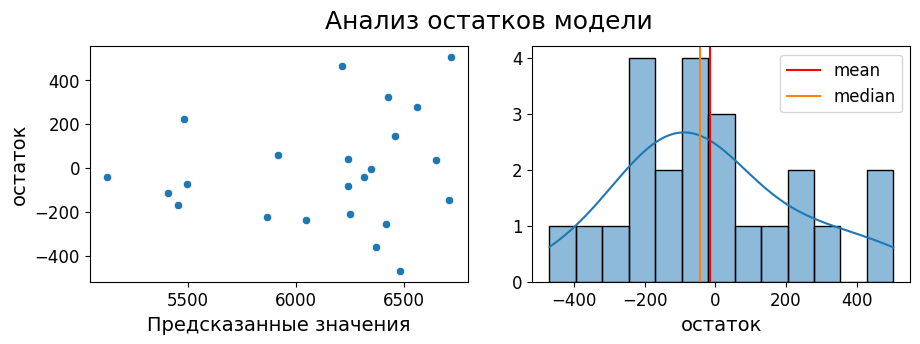

In [122]:
quality_model(y_test, prediction)

**Выводы:**
1. Модель построена достаточно хорошая для данных. С учетом того, что данных в целом немного. Можно уведеть, что остатки распределены беспорядочно, тенденцию  выявить почти невозможно. Однако на гистограмме мы не наблюдаем унимодальности свойственной нормальному распределению, отсюда следует, что есть факторы, которые мы не учли, но их мы наблюдать сейчас не можем. Из-за этого и учтённые факторы объясняют целевое значение всего на 80%.